# Automatic data labeling with snorkel-metal

John Brandt


Last Updated: August 15, 2019

## Loading and preprocessing data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import re
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import confusion_matrix, f1_score

from metal.label_model import LabelModel
from metal.analysis import lf_summary, label_coverage
from metal.label_model.baselines import MajorityLabelVoter

In [2]:
import pandas as pd
df = pd.read_csv("../data/interim/kenya-positive.csv")
df_negative = pd.read_csv("../data/interim/kenya-neutral.csv")
df_neutral = pd.read_csv("../data/interim/kenya-positive2.csv")
df_india_positive = pd.read_csv("../data/interim/india-positive.csv")
df_india_negative = pd.read_csv("../data/interim/india-negative.csv")
df_malawi_positive = pd.read_csv("../data/interim/malawi-positive.csv")

df = df.append(df_negative, ignore_index = True)
df = df.append(df_india_positive, ignore_index = True)
df = df.append(df_india_negative, ignore_index = True)
df = df.append(df_neutral, ignore_index = True)
df = df.append(df_malawi_positive, ignore_index = True)


df['label'] = range(0, len(df))
df = df[['label', 'sentences', 'class']]
df.reset_index()
df.to_csv('../data/interim/all.tsv', sep = '\t', index = False)

In [3]:
df['class'] = df['class'].map({'n' : 1, 'i' : 3, 'd' : 2})
df['class'][df['class'].isna()] = 1
to_positive = [28,  46, 48, 49, 82, 121]
df['class'].iloc[to_positive] = [3]*len(to_positive)

/Users/john.brandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/john.brandt/.local/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
df.to_csv("../data/processed/gold_standard.csv", index = False)

In [5]:
[x for x in df['sentences'][df['class'] == 2]]

['access to bank credit by farmers is still a major challenge despite the fact that kenya has a relatively well developed banking system. risks associated with agribusiness coupled with complicated land laws and tenure systems that limit the use of land as collateral make financing agriculture unattractive to the formal banking industry. in addition, corruption, political interference in the operations particularly of state owned banks, and a dysfunctional court system in the past, gave rise to a culture of defaulting that led to high numbers of non performing loans. this development forced many banks to charge their customers, who included farmers, prohibitively high interest rates to remain afloat. limited competition in the banking industry despite the large number of banks, also ensures interest rates remain high. the cost of bank credit and the limited number of banks in rural areas are some of the factors that make it difficult for farmers to access bank credit.',
 'after indepen

## Creating labeling functions

In [11]:
ABSTAIN = 0
NEUTRAL = 1
NEGATIVE = 2
POSITIVE = 3

from nltk.stem import PorterStemmer
ps = PorterStemmer()

def words_in_string(word_list, a_string):
    return list(set(word_list).intersection(a_string))

def split_and_search(string, l1 = ['finance', 'money'], l2 = ['provide', 'improve']):
    string = string.split(' ')
    string = [ps.stem(x) for x in string]
    
    l1 = [ps.stem(x) for x in l1]
    l2 = [ps.stem(x) for x in l2]
    
    list1 = words_in_string(l1, string)
    list2 = words_in_string(l2, string)
    
    loc1 = [i for i,val in enumerate(string) if val in list1]
    loc2 = [i for i,val in enumerate(string) if val in list2]
    if loc1 and loc2:
        min_diff = min([abs(x - y) for x, y in zip(sorted(loc1), sorted(loc2))])
        return min_diff
    else:
        return 999

verbs = ['improve', 'provide', 'establish', 'assist', 'raise', 'facilitate', 'increase',
        'mobilize', 'encourage', 'offer']

nouns = ['fund', 'investment', 'finance', 'credit', 'budget', 'resource']

neg_verbs_adj = ['limit', 'inadequate', 'insufficient', 'mismanage', 'little', 'high', 'lack', 'challenge']

neg_nouns = ['progress', 'cost', 'budget', 'credit', 'resource', 'investment', 'fund', 'interest',
            'finance', 'challenge', 'loan', 'capital']

def less_than_5(text):
    diff = split_and_search(text, l1 = verbs, l2 = nouns)
    return POSITIVE if diff < 10 else ABSTAIN

def negative_proximity(text):
    diff = split_and_search(text, l1 = neg_verbs_adj, l2 = neg_nouns)
    return NEGATIVE if diff < 5 else ABSTAIN

In [18]:
#TODO: Refine and granularize the LFs
#TODO: Go through false positives and update original labels --- Some of them are incorrect
#TODO: create tokenizing function with keras

to_add = ['reduce costs',
         'offer affordable','devolution fund', 'financing commitment',
          'increase resource allocation', 'will be financed by', 'delivery of financ',
         'encourage private investment', 'will be financed', 'delivery of financial']

TYPES_OF_FUNDS = r"""\b(microfinance|micro finance|grants|bilateral|multilateral|capital|concessional|
                            results based|philanthropic|carbon market|institutional finance|
                            budget allocation|budgetary allocation|financial assistance|micro financ|
                            funding mechanism|tax break|grant fund|youth enterprise fund|devolution fund|
                            financing commitment|international finance|green climate fund| sustainable financ|
                            development fund|adequate fund|private sector investment|forestry investment|
                            tax incentive|access to credit|devolved fund|revolving fund|financial mechanism|
                            budget support|taxation incentive|payment for ecosystem)"""

NEUTRAL_FINANCE = r"""\b(credit|investment|fund|grants|capital|support)"""

CREATING_FUNDS = r"""\b(financial support|funded by|provide funding|mobilize|provide investment|
                        offer funds|offer incentive|will be funded|increase investment|funding support|
                        budget support|taxation incentives|
                        mobilization of financ|encourage investment|facilitate investment|
                        improving the lending|raise funds|new investment|green growth|mobilising resources|earmark|
                        obtain funds|funds will be provided|additional funds|increase in investment|
                        fund established|access funds|access finance|mobilize finance|
                        provide finance|establish fund|establishment of an innovation fund|
                        offer affordable)"""

REDUCE_WORDS = r'''\b(reduce cost|lower cost|remove barriers|cost reduction|cost effective)'''

            
INCENTIVE = r"""\b(market connection|low transaction cost|payment system|funded by|provide funding|concessional|
                    results based|mobilize|carbon market|
                    provide investment opportunities|offer incentives|generated funds|
                    qualify for grants|budgetary allocation|credit packages|increase investment|
                    carbon credit|transfer pricing|mobilization of financ|encourage investment|
                    facilitate investment|access to finance|increased revenue|improving the lending|
                    market access|raise funds|access of|cost reduction|new investments|green growth|
                    mobilising resources|micro financing|accessing funds|institutional finance|
                    obtain funds|funds will be provided|tax free|additional funds|
                    financial incentives will)"""

NEG_WORDS = r"""\b(barriers|levied|evasion|penalty|excise|seizure|fee|disincentive|
                    not enough|fine|hampered|challenges|impede|guilty|
                    there is not|failed|there has not been|obstacle|corruption)"""

#neutral_finance
#neutral_incentives
#neutral_access

def neutral_funds(text):
    funds = re.search(CREATING_FUNDS, text)
    return ABSTAIN if funds else NEUTRAL

def neutral(text):
    inc = re.search(INCENTIVE, text)
    cre = re.search(TYPES_OF_FUNDS, text)
    dis = re.search(NEG_WORDS, text)
    create = re.search(CREATING_FUNDS, text)
    return ABSTAIN if inc or dis or cre or create else NEUTRAL

def reduce(text):
    return POSITIVE if re.search(REDUCE_WORDS, text) else ABSTAIN

def contains_incentive_words(text):
    return POSITIVE if re.search(INCENTIVE, text) else ABSTAIN

def negative(text):
    return NEGATIVE if re.search(NEG_WORDS, text) else ABSTAIN

def contains_funding_types(text):
    return POSITIVE if re.search(TYPES_OF_FUNDS, text) else ABSTAIN

def contains_fund_creation(text):
    return POSITIVE if re.search(CREATING_FUNDS, text) else ABSTAIN

def neutral_finance(text):
    return POSITIVE if re.search(NEUTRAL_FINANCE, text) else ABSTAIN

LFs = [
    contains_incentive_words,
    contains_funding_types,
    contains_fund_creation,
    negative,
    neutral,
    reduce,
    neutral_funds,
    less_than_5,
    negative_proximity,
]

LF_names = [
    'incentive',
    'types',
    'creation',
    'negative',
    'neutral',
    'reduce',
    'neutral_funds',
    'less_than_5',
    'negative_prox'
]

In [19]:
def make_Ls_matrix(data, LFs):
    noisy_labels = np.empty((len(data), len(LFs)))
    for i, row in data.iteritems():
        for j, lf in enumerate(LFs):
            noisy_labels[i][j] = lf(row.lower())
    return noisy_labels

LF_matrix = make_Ls_matrix(df['sentences'], LFs)
gold_standard = np.array(df['class'])
gold_standard = [np.int(x) for x in gold_standard]

LF_matrix = LF_matrix.astype(int)

In [20]:
lf_summary(sparse.csr_matrix(LF_matrix),
           Y=gold_standard,
           lf_names=LF_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
incentive,0,3,0.085189,0.085189,0.048403,74,14,0.840909
types,1,3,0.137464,0.137464,0.121007,106,36,0.746479
creation,2,3,0.060019,0.049371,0.001936,55,7,0.887097
negative,3,2,0.067764,0.067764,0.067764,26,44,0.371429
neutral,4,1,0.735721,0.735721,0.057115,588,172,0.773684
reduce,5,3,0.016457,0.016457,0.014521,11,6,0.647059
neutral_funds,6,1,0.939981,0.939981,0.261375,639,332,0.658084
less_than_5,7,3,0.095837,0.095837,0.068732,73,26,0.737374
negative_prox,8,2,0.021297,0.021297,0.021297,12,10,0.545455


In [15]:
label_coverage(LF_matrix)

1.0

## Baseline and label model

In [21]:
label_model = LabelModel(k=3, seed=42)
label_model.train_model(LF_matrix,
                        Y_dev=gold_standard,
                        n_epochs=1000,
                        lr=0.001,
                        log_train_every=200)

Computing O...
Estimating \mu...
[200 epo]: TRAIN:[loss=0.036]
[400 epo]: TRAIN:[loss=0.029]
[600 epo]: TRAIN:[loss=0.024]
[800 epo]: TRAIN:[loss=0.020]
[1000 epo]: TRAIN:[loss=0.017]
Finished Training


In [22]:
scores = label_model.score((LF_matrix, gold_standard),
                           metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.756
Precision: 0.748
Recall: 0.949
F1: 0.837
        y=1    y=2    y=3   
 l=1    613    39     167   
 l=2     0      0      0    
 l=3    33     13     168   


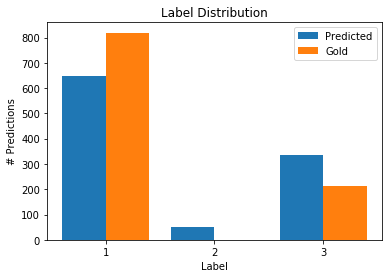

In [33]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)

Y_train_ps = label_model.predict_proba(LF_matrix)
Y_snorkel = label_model.predict(LF_matrix)
np.save("../data/interim/snorkel_proba", Y_train_ps)

plot_predictions_histogram(gold_standard,
                           label_model.predict(LF_matrix),
                           title="Label Distribution")

In [293]:
false = np.where(Y_snorkel != df['class'])
false_negatives = [x for x in false[0] if df['class'][x] == 2]
#false_positives = [x for x in false[0] if df['class'][x] == 3] # TRUE: Neutral, PRED: Incentive

In [ ]:
f_to_p = []
for x in false_negatives:
    print(x, df['sentences'][x], df['class'][x], Y_snorkel[x])